## Applications of Portfolio Management in Python

### By Evan Okin

### February 2020

This report contains 8 one-pagers designed to showcase examples of how Python can be used to assist a portfolio manager. Generally, Python is a lot more efficient than Excel, which allows the portfolio manager to spend more time on what matters.

The one-pagers are designed to give a high-level overview of the benefits of Python. The following are the 8 sections for the one-pagers:

Section 1: Use an API to pull in and analyze stock returns

Section 2: Find an “optimized” portfolio based on a set objective, such as maximizing Sharpe Ratio

Section 3: Create an options pricing calculator to value calls or puts using Black-Scholes

Section 4: Run Monte Carlo simulations of returns to assess portfolio volatility

Section 5: Create a robo-advisor based on individual preferences and risk capacity

Section 6: Test a hypothesis, such as if tech stocks outperform health care stocks

Section 7: Hedge a portfolio such that its exposed duration becomes nearly zero

Section 8: Apply Machine Learning algorithms to predict stock price

### Section 1: Use an API to pull in and analyze stock returns

In [1]:
import pandas as pd
import numpy as np
import datetime
import pandas_datareader.data as web

In [2]:
import warnings
warnings.simplefilter("ignore")

In [3]:
df=pd.read_excel('S&P500.xlsx')

In [4]:
list_of_stocks_to_pull=list(df['Symbol'])

In [5]:
list_of_stocks_to_pull=['AAPL','GOOG','FB']
start=datetime.datetime(2019,10,1) 
end=datetime.datetime(2020,2,1)
df=web.get_data_yahoo(list_of_stocks_to_pull, start, end,interval='m')

In [6]:
df=(web.get_data_yahoo(list_of_stocks_to_pull, start, 
                       end,interval='m')['Adj Close'])
df.head(3)

Symbols,AAPL,FB,GOOG
Date,,,
2019-10-01,247.428162,191.649994,1260.109985
2019-11-01,265.819183,201.639999,1304.959961
2019-12-01,292.954712,205.250000,1337.020020


In [7]:
df=df.pct_change()
df=df.dropna()
df.head(3)

Symbols,AAPL,FB,GOOG
Date,,,
2019-11-01,0.074329,0.052126,0.035592
2019-12-01,0.102083,0.017903,0.024568
2020-01-01,0.054010,-0.016273,0.072706


### Section 2: Find an “optimized” portfolio based on a set objective, such as maximizing Sharpe Ratio

In [8]:
import pandas as pd
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

In [9]:
df=pd.read_excel('HistoricalReturns.xlsx',header=1)
df=df.drop([0])
df.to_excel("AdjustedReturns.xlsx") 
df.drop('Symbols',axis=1,inplace=True)
df[df<0]=np.nan
df.dropna(axis=1,inplace=True)

In [10]:
mu = expected_returns.mean_historical_return(df)
S = risk_models.sample_cov(df)
ef = EfficientFrontier(mu, S)
raw_weights = ef.max_sharpe()
cleaned_weights = ef.clean_weights()
ef.save_weights_to_file("weights.csv")
print(cleaned_weights)

{'AAPL': 0.0, 'ACN': 0.0, 'ADBE': 0.0, 'ADP': 0.32207, 'ADSK': 0.0, 'AKAM': 0.0, 'ANSS': 0.0, 'CSCO': 0.0, 'CTSH': 0.0, 'CTXS': 0.19372, 'FIS': 0.0, 'FISV': 0.29363, 'FTNT': 0.0, 'HPQ': 0.0, 'IBM': 0.0, 'INTC': 0.0, 'INTU': 0.0, 'JKHY': 0.0, 'JNPR': 0.0, 'KLAC': 0.0, 'MA': 0.19058, 'MSI': 0.0, 'NVDA': 0.0, 'PAYX': 0.0, 'SNPS': 0.0, 'STX': 0.0}


In [11]:
df=pd.read_csv('weights.csv',header=-1)
df.rename(columns={0:'Company_Name',
                   1:'Optimal_Portfolio_Weight'},inplace=True)
optimal_weights=df[df['Optimal_Portfolio_Weight']!=0]
optimal_weights

,Company_Name,Optimal_Portfolio_Weight
3,ADP,0.32207
9,CTXS,0.19372
11,FISV,0.29363
20,MA,0.19058


### Section 3: Create an options pricing calculator to value calls or puts using Black-Scholes

In [12]:
import math
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
def Call_Price(t,r,vol,S,K): #Black-Scholes
    d1 = (1 / vol*math.sqrt(t)) * (math.log(S/K) + (r+((vol**2)/2))*t)
    d2 = d1 - vol*math.sqrt(t)
    N_d1 = stats.norm.cdf(d1)
    N_d2 = stats.norm.cdf(d2)
    Call_Price = round((N_d1 * S) - (N_d2 * K * math.exp(-r*t)),2)
    return(Call_Price)

In [14]:
volatility_amount, call_amount= ([] for i in range(2))
for i in range(5,100,5):
    volatility_amount.append(i/100)
    call_amount.append(Call_Price(1,.05,i/100,100,110))

Text(0, -50, 'T: 1 Year, R: 5%, S: 100, K: 110')

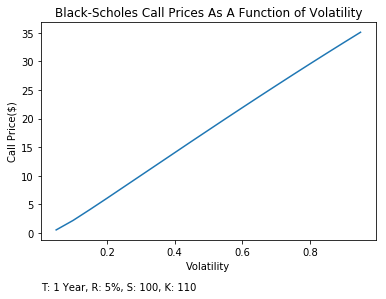

In [15]:
plt.plot(volatility_amount,call_amount)
plt.title('Black-Scholes Call Prices As A Function of Volatility')
plt.xlabel('Volatility')
plt.ylabel('Call Price($)')
plt.annotate('T: 1 Year, R: 5%, S: 100, K: 110', (0,0), (0, -50), 
             xycoords='axes fraction', textcoords='offset points')

### Section 4: Run Monte Carlo simulations of returns to assess portfolio volatility

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Max Account Value    1621.839633
dtype: float64
Min Account Value    762.763602
dtype: float64


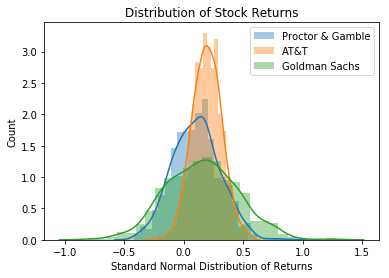

In [17]:
p=np.random.normal(.10,.20,1000)
t=np.random.normal(.20,.125,1000)
g=np.random.normal(.15,.30,1000)
sns.distplot(p)
sns.distplot(t)
sns.distplot(g)
plt.xlabel('Standard Normal Distribution of Returns')
plt.ylabel('Count')
plt.legend(['Proctor & Gamble','AT&T','Goldman Sachs'])
plt.title('Distribution of Stock Returns')
AV_returns=[]
for i in range(1000):
    AV_returns=[(1000/3)*(1+p)+(1000/3)*(1+t)+(1000/3)*(1+g)]
df=pd.DataFrame(AV_returns).T
df.rename(columns={0:'Account Value'},inplace=True)
print('Max '+ str(df.max()))
print('Min '+ str(df.min()))

### Section 5: Create a robo-advisor based on individual preferences and risk capacity

In [18]:
print('Hello, Welcome to Mini-Advisor.')

Hello, Welcome to Mini-Advisor.


In [19]:
risk_tolerance='risk_tolerance'
while ((risk_tolerance!='Aggressive') & 
    (risk_tolerance!='Conservative')):
    risk_tolerance=input('How would you define your risk tolerance?:')
# (Aggressive, Conservative)

How would you define your risk tolerance?:Aggressive


In [20]:
risk_capacity='risk_capacity'
while ((risk_capacity!='<1M') & (risk_capacity!='1-5M') & 
    (risk_capacity!='5+M')):
    risk_capacity=input('How much liquid assets do you have)?:') 
#   (<1M,1-5M,5+M))

How much liquid assets do you have)?:1-5M


In [21]:
if (risk_tolerance=='Aggressive') & (risk_capacity=='5+M'):
    print('Portfolio: Predominantly High-Risk Stocks')
elif (risk_tolerance=='Aggressive') & (risk_capacity=='1-5M'):
    print('Portfolio: Partially High-Risk Stocks, Partially S&P ETF')
elif (risk_tolerance=='Aggressive') & (risk_capacity=='<1M'):
    print('Portfolio: Predominantly S&P 500 ETF')
elif (risk_tolerance=='Conservative') & (risk_capacity=='5+M'):
    print('Portfolio: Predominantly S&P 500 ETF')
elif (risk_tolerance=='Conservative') & (risk_capacity=='1-5M'):
    print('Portfolio: Predominantly S&P 500 ETF')
else:
    print('Portfolio: Predominantly Treasury Bonds')

Portfolio: Partially High-Risk Stocks, Partially S&P ETF


### Section 6: Test a hypothesis, such as if tech stocks outperform health care stocks

In [22]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [23]:
tech_returns=pd.read_excel('Hypothesis_Test.xlsx',sheetname='Tech')
health_care_returns=pd.read_excel('Hypothesis_Test.xlsx',
                                  sheetname='Health_Care')

Null hypothesis (Ho): There is no significant difference in returns

Alternative hypothesis (Ha): There is a significant difference in returns

In [24]:
control=tech_returns['Percent Return']
experimental=health_care_returns['Percent Return']

In [25]:
control.mean()

9.756793479463854

In [26]:
experimental.mean()

4.281198379267195

In [27]:
experimental.mean()-control.mean()

-5.475595100196658

In [28]:
stats.ttest_ind(experimental, control,equal_var=False)

Ttest_indResult(statistic=-3.7585177072659626, pvalue=0.00047066769250311336)

The p-value is extremely small, far less than a typical 5% threshold.

We reject the null hypothesis. Results are statistically significant with p-value nearly 0.

Tech stocks have a significantly different returns profile than health care stocks.

### Section 7: Hedge a portfolio such that its exposed duration becomes nearly zero

In [29]:
import pandas as pd
import numpy as np

Suppose a portfolio has the following key rate durations:

In [30]:
KRD=pd.read_excel('Duration_Hedge.xlsx',sheetname='Sheet1')
Futures=pd.read_excel('Duration_Hedge.xlsx',sheetname='Sheet2')

We can buy/sell futures contracts to bring the net DV01 of the hedged portfolio to near zero.

In [31]:
Futures['2yr']=Futures['2yr']/100
Futures['5yr']=Futures['5yr']/100
Futures['10yr']=Futures['10yr']/100
Futures['Long Bond']=Futures['Long Bond']/100

In [32]:
n_long_futures=-KRD['Long Bond']/Futures.iloc[3]['Long Bond']

In [33]:
n_10yr_futures=-((KRD['10yr']+n_long_futures*Futures.iloc[3]['10yr'])/
                Futures.iloc[2]['10yr'])

In [34]:
n_5yr_futures=-((KRD['5yr']+n_long_futures*Futures.iloc[3]['5yr']
                +n_10yr_futures*Futures.iloc[2]['5yr'])/
                Futures.iloc[1]['5yr'])

In [35]:
n_2yr_futures=-((KRD['2yr']+n_long_futures*Futures.iloc[3]['2yr']
                +n_10yr_futures*Futures.iloc[2]['2yr']
                +n_5yr_futures*Futures.iloc[1]['2yr'])/
                Futures.iloc[0]['2yr'])

In [36]:
print('Hedge Portfolio with: ')
print('2 Year Futures: ' +str(n_2yr_futures[0]))
print('5 Year Futures: ' +str(n_5yr_futures[0]))
print('10 Year Futures: ' +str(n_10yr_futures[0]))
print('Long Futures: ' + str(n_long_futures[0]))
print('Positive: Long Position, Negative: Short Position')

Hedge Portfolio with: 
2 Year Futures: -49.44683050818985
5 Year Futures: -39.72044603223938
10 Year Futures: -9.89272155854012
Long Futures: -8.060605871700323
Positive: Long Position, Negative: Short Position


### Section 8: Apply Machine Learning algorithms to predict stock price

In [37]:
import pandas as pd
import numpy as np
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

Text(33.0, 0.5, 'True Value')

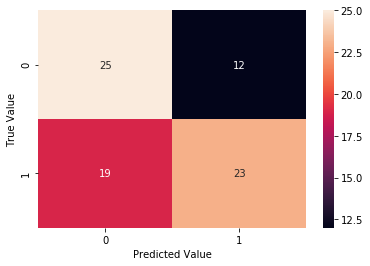

In [38]:
df=pd.read_excel('AAPL_ML.xlsx')
x=df.loc[:,['High','Low','Open','Volume']]
y=df.loc[:,'Adj Close']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3)
lm=LinearRegression()
lm.fit(x_train,y_train)
predictions=lm.predict(x_test)
y=df.loc[:,'Increase']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3)
dtree = DecisionTreeClassifier()
dtree.fit(x_train,y_train)
predictions=dtree.predict(x_test)
sns.heatmap(confusion_matrix(y_test,predictions),annot=True)
plt.xlabel('Predicted Value')
plt.ylabel('True Value')